# Exploratory Data Analysis

## Importation of the dataset, and first considerations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_auc_score, f1_score, accuracy_score, precision_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB, CategoricalNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
df = pd.read_csv('https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv')

In [ ]:
df.shape

(338427, 19)

This dataset presents 19 features and contains 338 427 examples.

In [ ]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,-11778.0,-4438.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,-11777.0,-4459.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,-21471.0,-1144.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18489.0,-3122.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19093.0,-3070.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1



The first column corresponds to an ID number. It should correspond to a unique value as it represents the client, but in this kind of dataset it is possible that this number is duplicated due to input from multiple sources or snapshots in time. </br>
The next code block checks the eventual ID duplicates.

In [ ]:
duplicated = df[df.duplicated(subset='ID', keep=False)]

# Grouped the 'ID' duplicated examples
grouped_duplicated = duplicated.groupby('ID')

# Visualize the duplicated examples
if not duplicated.empty:
    print("Founded duplicated examples:")
    for id_val, group in grouped_duplicated:
        print(f"\nID duplicated: {id_val}")
        print(group)
else:
    print("There are no 'ID' duplicated.")

There are no 'ID' duplicated.


As there is no duplicated example, the 'ID' column will be dropped as it is not usefull for the rest of this study.

In [ ]:
df = df.drop("ID", axis=1)

In order to have the maximum information in this first explorative phase, we create a function to show for each feature its type, the eventual number of absent data, its categories and the frequency of each one.

In [ ]:
def exploration(df):
  summary_data = []

  for feature in df.columns:
    col_type = df[feature].dtype
    num_of_nulls = df[feature].isnull().sum()
    num_of_categories = df[feature].nunique()
    if num_of_categories < 10:
      categories_counts = df[feature].value_counts().to_dict()
    else:
      categories_counts = None


    summary_data.append({
        'feature': feature,
        'col_type': col_type,
        'num_of_nulls': num_of_nulls,
        'num_of_categories': num_of_categories,
        'categories_counts': categories_counts
    })

  summary_df = pd.DataFrame(summary_data)
  return summary_df

In [ ]:
summary_df = exploration(df)
display(summary_df)

,feature,col_type,num_of_nulls,num_of_categories,categories_counts
0,CODE_GENDER,object,0,2,"{'F': 227916, 'M': 110511}"
1,FLAG_OWN_CAR,object,0,2,"{'N': 213196, 'Y': 125231}"
2,FLAG_OWN_REALTY,object,0,2,"{'Y': 231307, 'N': 107120}"
3,CNT_CHILDREN,int64,0,12,None
4,AMT_INCOME_TOTAL,float64,0,335045,None
5,NAME_INCOME_TYPE,object,0,5,"{'Working': 174366, 'Commercial associate': 78..."
6,NAME_EDUCATION_TYPE,object,0,6,"{'Secondary / secondary special': 232568, 'Hig..."
7,NAME_FAMILY_STATUS,object,1,5,"{'Married': 231494, 'Single / not married': 42..."
8,NAME_HOUSING_TYPE,object,1,6,"{'House / apartment': 304410, 'With parents': ..."
9,DAYS_BIRTH,float64,1,17432,None


The target is binary: 1 means the client is creditworthy, and 0 means he is not.

There are several binary features:

*   CODE_GENDER
*   FLAG_OWN_CAR
*   FLAG_OWN_REALTY
*   FLAG_MOBIL
*   FLAG_PHONE
*   FLAG_WORK_PHONE
*   FLAG_EMAIL

Some variables are disjoint categorical:

*   NAME_INCOME_TYPE
*   NAME_FAMILY_STATUS
*   NAME_HOUSING_TYPE
*   OCCUPATION_TYPE

Another is ordinal categorical:

*   NAME_EDUCATION_TYPE

Others are discrete quantitative variables:

*   CNT_CHILDREN
*   DAYS_BIRTH
*   DAYS_EMPLOYED
*   CNT_FAM_MEMBERS


And there is only one continue quantitative:

*   AMT_INCOME_TOTAL




We also note that for 9 features, there is a missing data. We investigate on it. </br>
There are 103 342 missing values for OCCUPATION_TYPE feature, so without considering it, we create a list of the examples indexes containing missing data.

In [ ]:
ex_with_nan = df[df.drop("OCCUPATION_TYPE", axis=1).isnull().any(axis=1)].index.tolist()
print(ex_with_nan)

[338426]


In [ ]:
df.iloc[338426]

,338426
CODE_GENDER,F
FLAG_OWN_CAR,N
FLAG_OWN_REALTY,N
CNT_CHILDREN,0
AMT_INCOME_TOTAL,68765.48
NAME_INCOME_TYPE,Working
NAME_EDUCATION_TYPE,Secondary / se
NAME_FAMILY_STATUS,NaN
NAME_HOUSING_TYPE,NaN
DAYS_BIRTH,NaN


In fact, the example number 338 426 shows many missing data: it is preferable to remove it.

In [ ]:
df = df.drop(df.index[338426])

In [ ]:
df.shape

(338426, 18)

## Univariate Analysis

To proceed with the univariate analysis, the features are picked up from the dataset following the columns order.

### Gender (CODE_GENDER)

In [ ]:
def perc_count(y):
  counts = y.value_counts()
  mod_0 = y.unique()[0]
  mod_1 =y.unique()[1]
  print(f"{mod_0} = {counts[mod_0]} (corresponding to {counts[mod_0]/counts.sum()*100:.2f}%)")
  print(f"{mod_1} = {counts[mod_1]} (corresponding to {counts[mod_1]/counts.sum()*100:.2f}%)")

perc_count(df["CODE_GENDER"])

M = 110511 (corresponding to 32.65%)
F = 227915 (corresponding to 67.35%)


Proportionnaly in this dataset there are 2 women for 1 man. </br>
To preprocess this feature, a label encoding is done.

In [ ]:
gender_mapping = {"M": 0, "F": 1}
df["CODE_GENDER"] = df["CODE_GENDER"].map(gender_mapping)

### Own car (FLAG_OWN_CAR)

In [ ]:
perc_count(df["FLAG_OWN_CAR"])

Y = 125231 (corresponding to 37.00%)
N = 213195 (corresponding to 63.00%)


The main part of the clients in this dataset don't own their own car. </br>
As well as for gender feature, FLAG_OWN_CAR is submitted to label encoding.

In [ ]:
flag_mapping = {"N": 0, "Y": 1}
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].map(flag_mapping)

### Own realty (FLAG_OWN_REALTY)

In [ ]:
perc_count(df["FLAG_OWN_REALTY"])

Y = 231307 (corresponding to 68.35%)
N = 107119 (corresponding to 31.65%)


The main part of the clients in this dataset own an appartment or a house. </br>
As well as for gender feature, FLAG_OWN_REALTY is submitted to label encoding.

In [ ]:
df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].map(flag_mapping)

### Number of children (CNT_CHILDREN)

In [ ]:
frequency_absolute = df['CNT_CHILDREN'].value_counts()
frequency_relative = df['CNT_CHILDREN'].value_counts(normalize=True)*100

frequency_table = pd.DataFrame({
    'Absolute frequency': frequency_absolute,
    'Relative frequency, in %': round(frequency_relative,4)
})

# It seems more comprensible to order the data "number of children" in crescent order
frequency_table_sorted = frequency_table.sort_index()

print(frequency_table_sorted)

              Absolute frequency  Relative frequency, in %
CNT_CHILDREN                                              
0                         234630                   69.3298
1                          67922                   20.0700
2                          31117                    9.1946
3                           4252                    1.2564
4                            367                    0.1084
5                            120                    0.0355
6                              4                    0.0012
7                              2                    0.0006
9                              4                    0.0012
12                             4                    0.0012
14                             3                    0.0009
19                             1                    0.0003


In Europe surveys showed that 73% of families don't have children, 12% have one kid, 9% have two kids and only 3% have three children or less (Source: Eurostat data, European Statitics Institute, 2022). </br>
It seems that the data presented here could correspond to an european-like sample population.

### Annual income (AMT_INCOME_TOTAL)

As we can expect many outliers for the very high values, the x maximum for visualization is set to a value of 1 000 000.

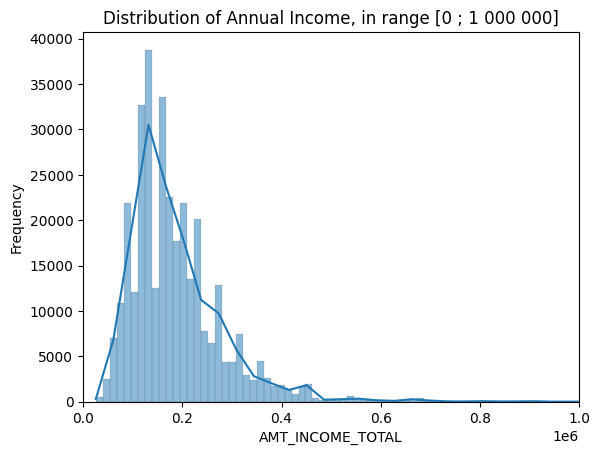

In [ ]:
figure, ax = plt.subplots()
sns.histplot(df['AMT_INCOME_TOTAL'], kde=True, ax=ax, bins=500)
ax.set_ylabel('Frequency')
ax.set_xlim(0, 1000000)
ax.set_title('Distribution of Annual Income, in range [0 ; 1 000 000]')
plt.show()

To better describe this density of distribution, skewness and kurtosis are calculated.

In [ ]:
from scipy.stats import skew, kurtosis
print(f"Skewness: {skew(df['AMT_INCOME_TOTAL']):.0f}, Kurtosis: {kurtosis(df['AMT_INCOME_TOTAL']):.0f}")

Skewness: 9, Kurtosis: 362


The density of annual income presents a positive assymetry and is leptokurtic.

### Income type (NAME_INCOME_TYPE)

In [ ]:
def perc_count_mod(y):
  n = y.nunique()
  counts = y.value_counts()
  mod = []
  for i in range(n):
    mod.append(y.unique()[i])
    print(f"{mod[i]} = {counts[mod[i]]} (corresponding to {counts[mod[i]]/counts.sum()*100:.2f}%)")
  return None

In [ ]:
perc_count_mod(df['NAME_INCOME_TYPE'])

Working = 174365 (corresponding to 51.52%)
Commercial associate = 78090 (corresponding to 23.07%)
Pensioner = 57841 (corresponding to 17.09%)
State servant = 28113 (corresponding to 8.31%)
Student = 17 (corresponding to 0.01%)


Half of the clients are workers, 23% are commercial associates, 17% are retired, 8% are state servant and 0.01% are students. </br>


### Education type (NAME_EDUCATION_TYPE)

This feature presents the higher education level received.

In [ ]:
perc_count_mod(df['NAME_EDUCATION_TYPE'])

Higher education = 91062 (corresponding to 26.91%)
Secondary / secondary special = 232568 (corresponding to 68.72%)
Incomplete higher = 11387 (corresponding to 3.36%)
Lower secondary = 3177 (corresponding to 0.94%)
Academic degree = 232 (corresponding to 0.07%)


Naming each level with its associated frequency from the lower level to the higher, we have:
*   Lower Secondary: 1%
*   Secondary / secondary special: 69%
*   Incomplete higher: 3%
*   Higher education: 27%
*   Academic degree: 0.07%

As it is possible to order these labels by instruction level ; to encode this feature we use label encoding.

In [ ]:
education_mapping = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}

df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].map(education_mapping)

### Family situation (NAME_FAMILY_STATUS)

In [ ]:
perc_count_mod(df['NAME_FAMILY_STATUS'])

Civil marriage = 28516 (corresponding to 8.43%)
Married = 231494 (corresponding to 68.40%)
Single / not married = 42509 (corresponding to 12.56%)
Separated = 20809 (corresponding to 6.15%)
Widow = 15098 (corresponding to 4.46%)


Main part of this population is married (68%), nearly 13% is single, 8% had a civil marriage, 6% are separated and 4% are widows. </br>
We note that religious and civial marriage could be grouped.

### Type of residence (NAME_HOUSING_TYPE)

In [ ]:
perc_count_mod(df['NAME_HOUSING_TYPE'])

Rented apartment = 4442 (corresponding to 1.31%)
House / apartment = 304410 (corresponding to 89.95%)
Municipal apartment = 10819 (corresponding to 3.20%)
With parents = 14625 (corresponding to 4.32%)
Co-op apartment = 1162 (corresponding to 0.34%)
Office apartment = 2968 (corresponding to 0.88%)


Nearly 9 out of 10 clients live in their own house or appartement. An alternative is living with parents (probably mainly for students) for 4%, then 3% live in public housing. </br>
Only 1.3% of the clients live in rented apartement. The tendency for people to rent a house or an apartement is strongly correlated with the cultural and living politics of each country. For instance in Europe Germany is the only one country with more people renting houses than owning them (Eurostat, February the 2nd, 2024).

### Age (DAYS_BIRTH)

The age of clients is expressed in days. It is of course preferable to convert it in years, and then to change feature name.

In [ ]:
df['DAYS_BIRTH'] = -df['DAYS_BIRTH']//365.25
df = df.rename(columns={'DAYS_BIRTH': 'AGE'})

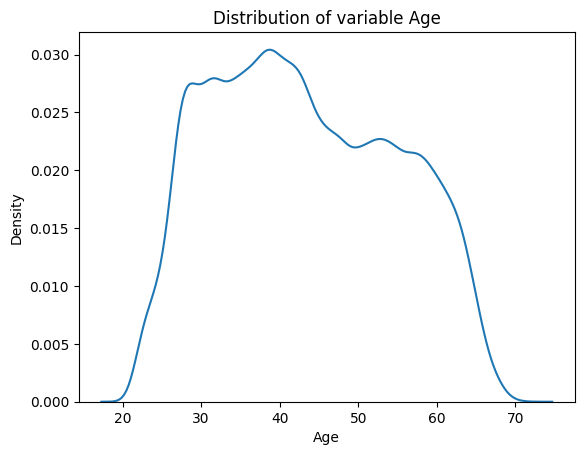

In [ ]:
sns.kdeplot(df["AGE"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Distribution of variable Age")
plt.show()

### Working activity duration (DAYS_EMPLOYED)

This feature as the previous one in expressed in days. So the first thing to do is to convert it as years, and modify its name.

In [ ]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED']//365.25
df = df.rename(columns={'DAYS_EMPLOYED': 'WORK_DURATION'})

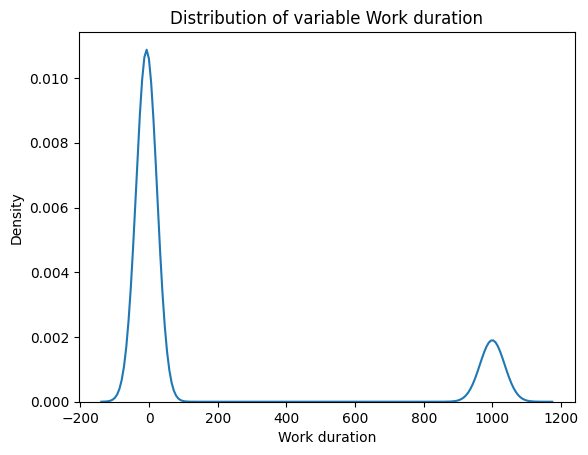

In [ ]:
sns.kdeplot(df["WORK_DURATION"])
plt.xlabel("Work duration")
plt.ylabel("Density")
plt.title("Distribution of variable Work duration")
plt.show()

Negative values indicate a working period while positive values an unemployed period. </br> We expect a distribution around 0. </br>
It is surprising to observe a population around 1000 years, which should corresponds to 1000 years of unemployment. </br>
A specific study is done to understand this population of clients.

In [ ]:
# A criterion of WORK_DURATION > 800 is chosen to select this population
df_1000 = df[df['WORK_DURATION'] > 800]
perc_count_mod(df_1000['NAME_INCOME_TYPE'])

Pensioner = 57841 (corresponding to 100.00%)


This value of 1000 years of unemployement has been created for retired people. </br>
One could think that pensioner are particularly creditworthy, but let's see their target value.

In [ ]:
df_1000["TARGET"].value_counts()

,count
TARGET,
0,57841


The entire population of pensioners are considered as not creditworthy. This explains why a positive value of +1000 years has been chosen for this feature.

### Possession of mobile phone (FLAG_MOBIL)

In [ ]:
df['FLAG_MOBIL'].value_counts()

,count
FLAG_MOBIL,
1.0,338426


As all clients own a mobile (100% of flagged answers), this feature can be eliminated from the dataset.

In [ ]:
df = df.drop("FLAG_MOBIL", axis=1)

### Possession of work phone, phone and email (FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL)

In [ ]:
flags = ['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
count_0_perc = []
count_1_perc = []
count_0 = []
count_1 = []

for feature in flags:
  counts = df[feature].value_counts().sum()
  mod_0 = df[feature].value_counts()[0]
  mod_0_perc = round(df[feature].value_counts()[0]/counts*100, 2)
  mod_1 = df[feature].value_counts()[1]
  mod_1_perc = round(df[feature].value_counts()[1]/counts*100, 2)

  count_0.append(mod_0)
  count_1.append(mod_1)
  count_0_perc.append(mod_0_perc)
  count_1_perc.append(mod_1_perc)

data = {"Flag": ['Work phone', 'Phone', 'Email'], "Negative count": count_0, "Negative %":count_0_perc, "Positive count": count_1, "Positive %":count_1_perc}
df_flags = pd.DataFrame(data)
print(df_flags)


         Flag  Negative count  Negative %  Positive count  Positive %
0  Work phone          266890       78.86           71536       21.14
1       Phone          239165       70.67           99261       29.33
2       Email          302830       89.48           35596       10.52


Negative answers for each of these three features are majoritary: nearly 90% answered they don't have an email, 70% don't have a phone and 79% don't have a work phone. </br>
We note that they also could answered non-flagging the box to avoid some undesiderable communication.

### Work type (OCCUPATION_TYPE)

In [ ]:
print(df["OCCUPATION_TYPE"].value_counts())
print(f'Quantity of NaN: {df["OCCUPATION_TYPE"].isnull().sum()} examples')

OCCUPATION_TYPE
Laborers                 60146
Core staff               33527
Sales staff              31652
Managers                 27384
Drivers                  20020
High skill tech staff    13399
Accountants              12281
Medicine staff           10438
Cooking staff             6248
Security staff            6218
Cleaning staff            4594
Private service staff     2787
Low-skill Laborers        1714
Secretaries               1577
Waiters/barmen staff      1245
Realty agents              852
HR staff                   567
IT staff                   436
Name: count, dtype: int64
Quantity of NaN: 103341 examples


There are many workers categories, and a total of 103 341 missing data for this feature. </br>
As we have an Income type feature with 'Pensioner' as category, when there is a missing value for OCCUPATION_TYPE and the NAME_INCOME_TYPE is 'Pensioner', the OCCUPATION_TYPE is modified for 'Retired', otherwise it gets the 'Missing' label.

In [ ]:
if df["OCCUPATION_TYPE"].isnull().any(): # Check if any value in the column is null
    # Access the 'WORK_DURATION' column only for rows with missing 'OCCUPATION_TYPE'
    work_duration_null_occupation = df.loc[df['OCCUPATION_TYPE'].isnull(), 'WORK_DURATION']

    # Update 'OCCUPATION_TYPE' based on conditions
    df.loc[(df['OCCUPATION_TYPE'].isnull()) & (df['NAME_INCOME_TYPE']=='Pensioner'), 'OCCUPATION_TYPE'] = "Retired"
    df.loc[(df['OCCUPATION_TYPE'].isnull()), 'OCCUPATION_TYPE'] = "Missing"

In [ ]:
print(df["OCCUPATION_TYPE"].value_counts())
print(f'Quantity of NaN: {df["OCCUPATION_TYPE"].isnull().sum()} examples')

OCCUPATION_TYPE
Laborers                 60146
Retired                  57841
Missing                  45500
Core staff               33527
Sales staff              31652
Managers                 27384
Drivers                  20020
High skill tech staff    13399
Accountants              12281
Medicine staff           10438
Cooking staff             6248
Security staff            6218
Cleaning staff            4594
Private service staff     2787
Low-skill Laborers        1714
Secretaries               1577
Waiters/barmen staff      1245
Realty agents              852
HR staff                   567
IT staff                   436
Name: count, dtype: int64
Quantity of NaN: 0 examples


As a result, the category 'Retired' counts 57 841 examples (exactly as the 'Pensioner' of NAME_INCOME_TYPE, and the 'Missing' one counts 45 500.

### Household composition (CNT_FAM_MEMBERS)

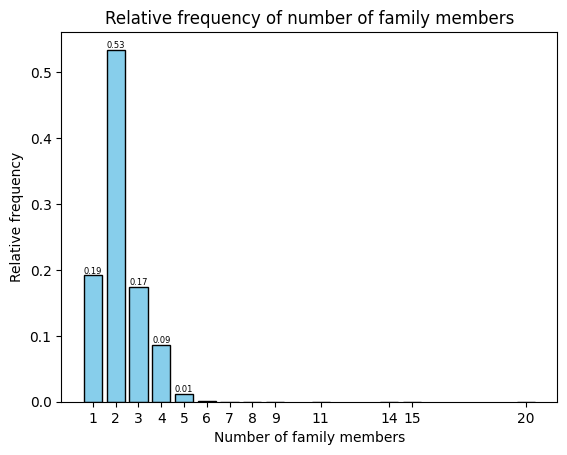

In [ ]:
freq_rel = df['CNT_FAM_MEMBERS'].value_counts(normalize=True)
plt.bar(freq_rel.index, freq_rel.values, color='skyblue', edgecolor='black')

for x, y in zip(freq_rel.index, freq_rel.values):
  if y > 0.005:
    plt.text(x, y, str(round(y,2)), ha='center', va='bottom', fontsize=6)

plt.title('Relative frequency of number of family members')
plt.xlabel('Number of family members')
plt.ylabel('Relative frequency')
plt.xticks(df['CNT_FAM_MEMBERS'].unique())
plt.show()

As seen before, 68% + 8% people are married (from NAME_FAMILY_STATUS feature), and 69% don't have children, it was expected that the major category of family members number would be 2 (53% as visible on the upper barplot).

### Creditworthiness (TARGET)

Last but not least, let's check on the target.

In [ ]:
perc_count(df["TARGET"])

0 = 308704 (corresponding to 91.22%)
1 = 29722 (corresponding to 8.78%)


In this dataset, the extreme majority of clients are considered as not creditworthy people, with 91% of the total, while the leaving 9% are. </br>
As a result, this dataset is unbalanced, and some special considerations will be taken to deal with it for the model creation.

## Multivariate Analysis

### Between quantitative features

Considering only the quantitative variables, a correlation map is done.

<Axes: >

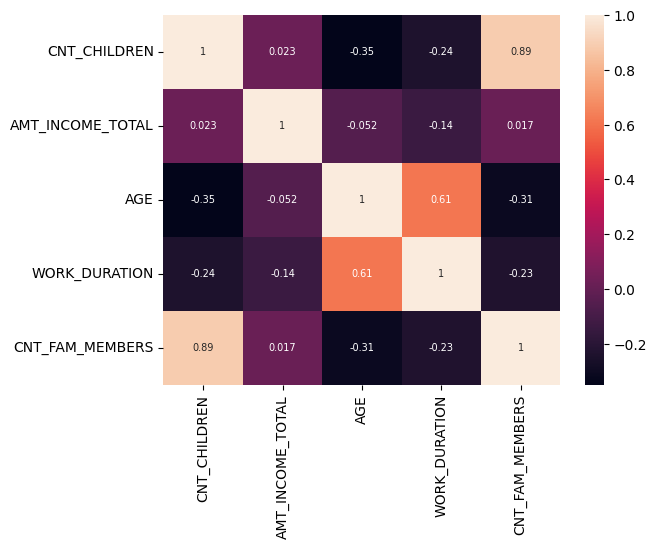

In [ ]:
df_corr = df[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AGE", "WORK_DURATION", "CNT_FAM_MEMBERS"]]
sns.heatmap(df_corr.corr(), annot=True, annot_kws={"fontsize": 7})

The only one significant correlation is between CNT_FAM_MEMBERS and CNT_CHILDREN: the children a client has are present as family members.

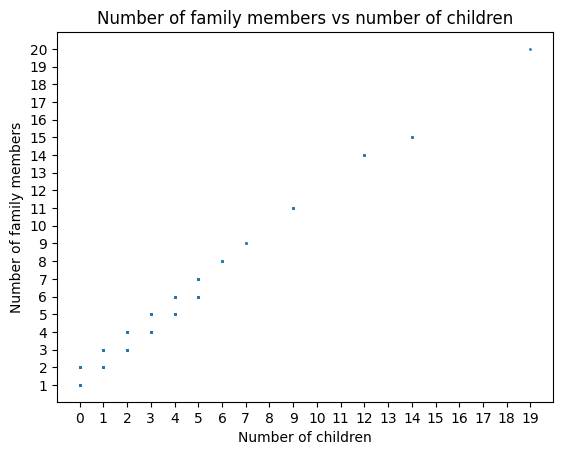

In [ ]:
x = df['CNT_CHILDREN']
y = df['CNT_FAM_MEMBERS']
plt.scatter(x, y, s=1);
plt.xlabel('Number of children')
plt.ylabel('Number of family members')
plt.title('Number of family members vs number of children')
plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.yticks(np.arange(min(y), max(y)+1, 1))
plt.show()

As a result, to prevent multicollinearity issues, the feature 'CNT_CHILDREN' is not kept.

In [ ]:
df = df.drop("CNT_CHILDREN", axis=1)

### Between qualitative features

As similarly done for quantitative variables, a map is done representing the p-value of the chi-test between each couple of qualitative variables.

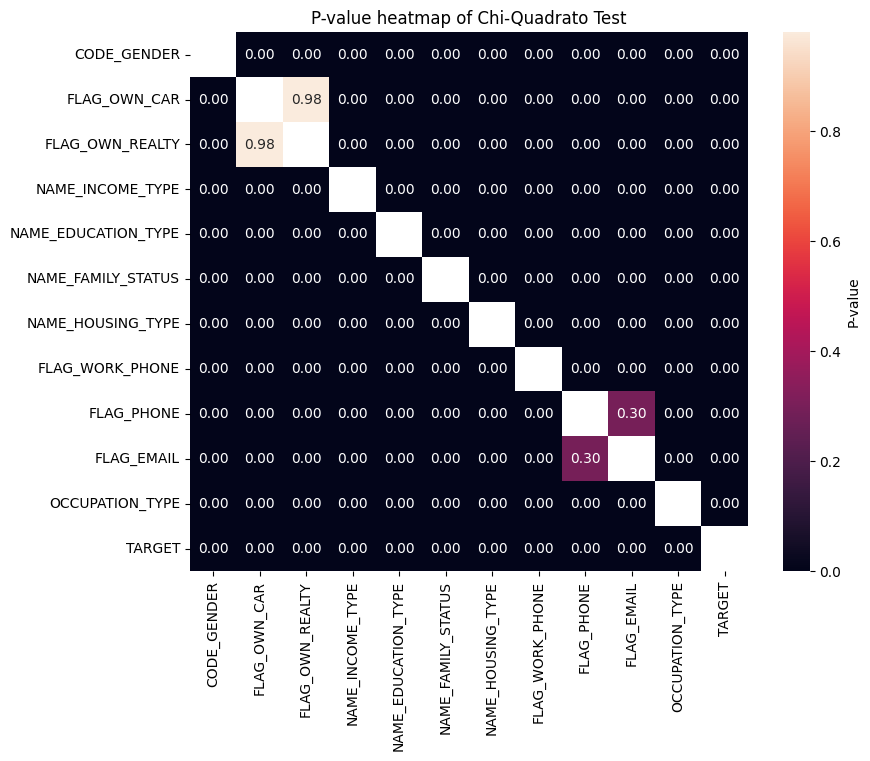

In [ ]:
df_qual = df[["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE",
              "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE",
              'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
              'TARGET']]

# List of variables
variables = df_qual.columns

# Matrix creation to present p values
p_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), index=variables, columns=variables)

# p-value calculation of each chi test for the couple of variables, except the variable with itself.
for var1 in variables:
    for var2 in variables:
        if var1 != var2:
            contingency_table = pd.crosstab(df[var1], df[var2])
            _, p, _, _ = chi2_contingency(contingency_table)
            p_matrix.loc[var1, var2] = p
        else:
            p_matrix.loc[var1, var2] = np.nan

# Heatmap visualizzazion with p values
plt.figure(figsize=(9, 7))
sns.heatmap(p_matrix, annot=True, cbar_kws={'label': 'P-value'}, fmt=".2f")
plt.title('P-value heatmap of Chi-Quadrato Test')
plt.show()

The couples of variables:
- flags of own realty & own car
- flags of email and phone </br>
are independant, as p-value > 0.05.

P-values close to 0 should indicate a close correlation between variables. To keep investigating for the other couples of variables, a matrix is created with the Cramer's V.

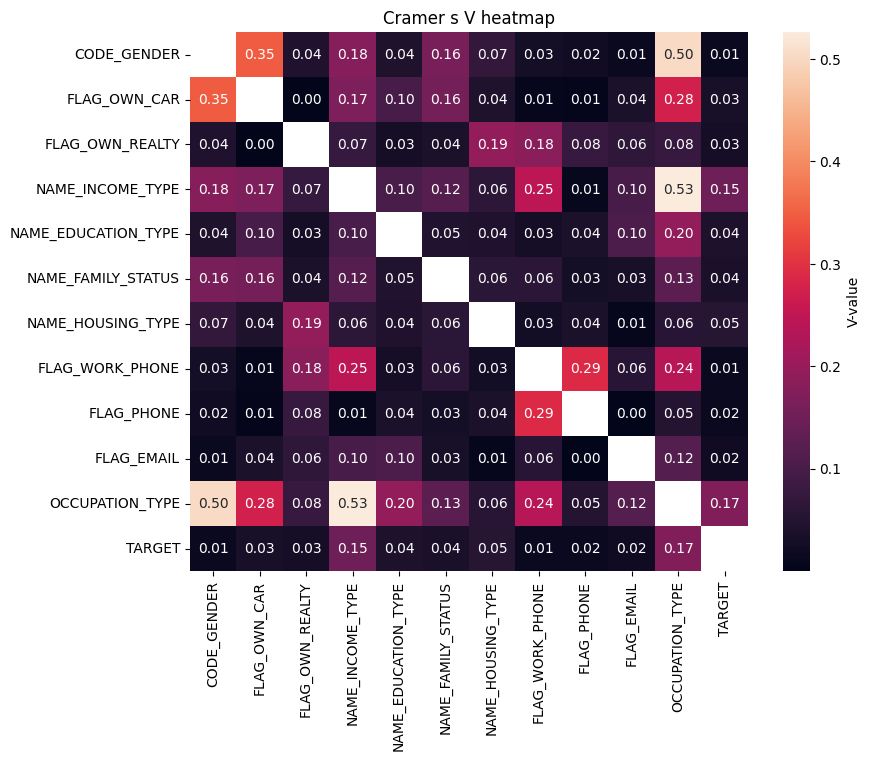

In [ ]:
# Matrix creation to present V values
v_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), index=variables, columns=variables)

# V-value calculation of each couple of variables, except the variable with itself.
for var1 in variables:
    for var2 in variables:
        if var1 != var2:
            contingency_table = pd.crosstab(df[var1], df[var2])
            v = association(contingency_table.values, method='cramer')
            v_matrix.loc[var1, var2] = v
        else:
            v_matrix.loc[var1, var2] = np.nan

# Heatmap visualizzazion with V values
plt.figure(figsize=(9, 7))
sns.heatmap(v_matrix, annot=True, cbar_kws={'label': 'V-value'}, fmt=".2f")
plt.title('Cramer s V heatmap')
plt.show()

We note that the target is directly associated mostly with the type of occupation and the type of income of the client (NAME_INCOME_TYPE and OCCUPATION_TYPE). In fact these 2 variables are very strongly correlated, as the Cramer's V is equal to 0.53. </br>
We also see that the type of occupation (OCCUPATION_TYPE) is the variable with the major quantity of strong correlations with Cramer's V beyond 0.2 for CODE_GENDER (men and women have different kind of work opportunities), FLAG_OWN_CAR (often the type of work implies to own a car), NAME_EDUCATION_TYPE (the kind of studies and the level of education directly impact the work), and finally the type of work influences the possession of a work phone (FLAG_WORK_PHONE).

### Between qualitative and quantitative features

As last part of this multivariate analysis, a focus is done on the correlation between the target and the quantitative features using T test.

In [ ]:
# T-test function
def corr_quant_qual(data, y1, y2): #y1 quantitative, y2 qualitative dichotomous 0/1
  # define group1 and group2 to be compared
  group1 = data[data[y2[0]]==data[y2[0]].unique()[0]]
  group2 = data[data[y2[0]]==data[y2[0]].unique()[1]]

  # perform t-test
  _, p_value = stats.ttest_ind(group1[y1[0]], group2[y1[0]])

  if p_value<0.05:
    print(f"Target and {feature} correlated: P-value = {p_value:.2f}")

  else:
    print(f"Target and {feature} non correlated: P-value = {p_value:.2f}")

In [ ]:
quant_features = ["AMT_INCOME_TOTAL", "AGE", "WORK_DURATION", "CNT_FAM_MEMBERS"]
for feature in quant_features:
  corr_quant_qual(df, [feature], ['TARGET'])

Target and AMT_INCOME_TOTAL correlated: P-value = 0.00
Target and AGE correlated: P-value = 0.00
Target and WORK_DURATION correlated: P-value = 0.00
Target and CNT_FAM_MEMBERS correlated: P-value = 0.00


As p-values are all very close to 0, some plots are done in order to better appreciate these correlations.

#### Total Income and Target

<ipython-input-662-815b7261fe1e>:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['0', '1'], patch_artist=False);


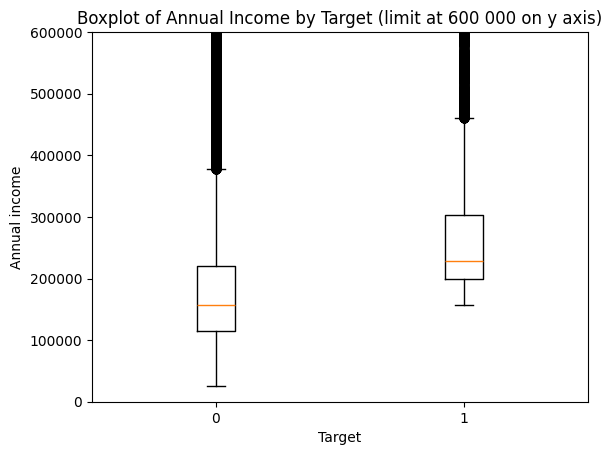

In [ ]:
# Extract the data for each target group
data_0 = df[df['TARGET'] == 0]['AMT_INCOME_TOTAL']
data_1 = df[df['TARGET'] == 1]['AMT_INCOME_TOTAL']

plt.boxplot([data_0, data_1], labels=['0', '1'], patch_artist=False);

plt.ylabel('Annual income')
plt.xlabel('Target')
plt.title('Boxplot of Annual Income by Target (limit at 600 000 on y axis)')
plt.ylim(0, 600000)

plt.show()

On this plot, outliers have been cut off. </br>
As logical, clients with major annual income are more likely creditworthy.

#### Work duration and Target

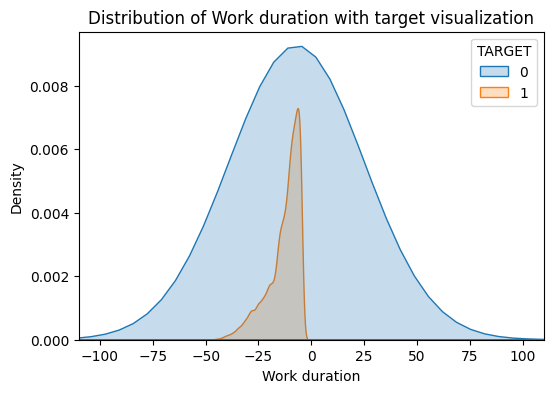

In [ ]:
data = df[["WORK_DURATION", "TARGET"]]

# Creation of the conditional density plot
plt.figure(figsize=(6, 4))
sns.kdeplot(data=data, x='WORK_DURATION', hue='TARGET', fill=True)

# Plot show
plt.title('Distribution of Work duration with target visualization')
plt.xlabel('Work duration')
plt.xlim(-110, 110)
plt.ylabel('Density')
plt.show()

This density plot clearly evidenciates that good creditworthiness (target = 1) means to be employed (negative work duration value).

#### Number of family members and Target

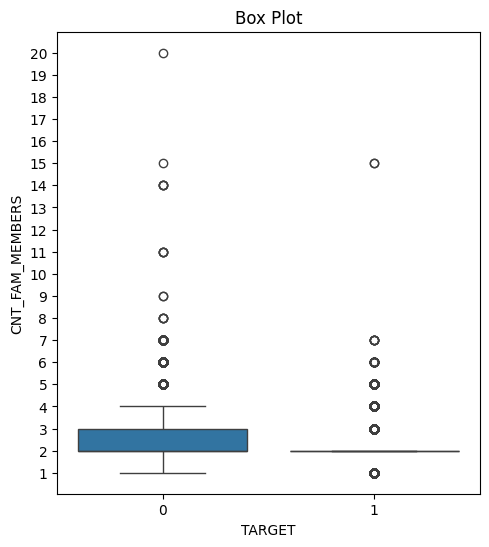

In [ ]:
data = df[["CNT_FAM_MEMBERS", "TARGET"]]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='TARGET', y='CNT_FAM_MEMBERS', data=data)
plt.title('Box Plot')
plt.yticks(np.arange(min(y), max(y)+1, 1))
plt.show()

There are outliers in both target groups, but the boxplot itself for positive target is all on family members number equals to 2. </br>
We would like to investigate if this group mainly corresponds to a couple (as we could logically think) or if it can be an adult and a child. </br>
So first, we select from the original dataset only people with target = 1 and number of family members = 2. In this, we plot on a barplot the relative frequency for numbers of children.

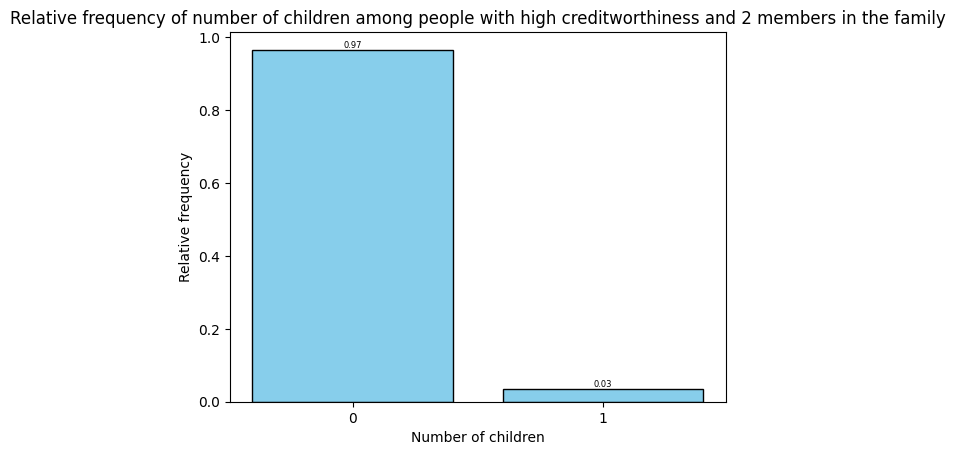

In [ ]:
# Import of the original dataset
df_2 = pd.read_csv('https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv')

# Selection of the examples
group = df_2[(df_2['TARGET'] == 1) & (df_2['CNT_FAM_MEMBERS'] == 2)]

# Creation of the barplot
freq_rel = group['CNT_CHILDREN'].value_counts(normalize=True)
plt.bar(freq_rel.index, freq_rel.values, color='skyblue', edgecolor='black')

for x, y in zip(freq_rel.index, freq_rel.values):
  plt.text(x, y, str(round(y,2)), ha='center', va='bottom', fontsize=6)

plt.title('Relative frequency of number of children among people with high creditworthiness and 2 members in the family')
plt.xlabel('Number of children')
plt.ylabel('Relative frequency')
plt.xticks(group['CNT_CHILDREN'].unique())
plt.show()

As hypothesized, in 97% of the cases it corresponds to couple without kids. And only in 3%, it is a single parent family.

#### Age and Target

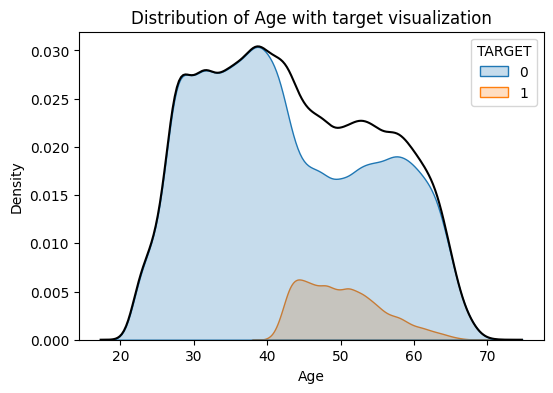

In [ ]:
data = df[["AGE", "TARGET"]]

# Creation of the conditional density plot
plt.figure(figsize=(6, 4))
sns.kdeplot(data=data, x='AGE', hue='TARGET', fill=True)
sns.kdeplot(data=data, x='AGE', c='black')

# Plot show
plt.title('Distribution of Age with target visualization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

On this density plot, it is visible that there are 2 clear populations of clients (black line): the first in range 30-40 years old, and the second in 50-60 year old. </br>
The population with target = 1 is an in-between part of the total population, with age between 43-51 years old. Based on the previous observations, we know that oldest clients, mainly retired, are not creditworthy, and probably youngest people don't have a sufficient total income.</br>
To check this hypothesis, a plot of mean annual income vs age is done.

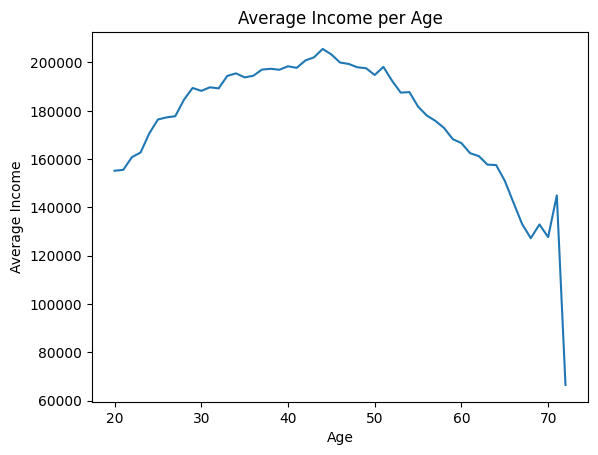

In [ ]:
data = df[["AMT_INCOME_TOTAL", "AGE"]]

# Mean annual income for eah age
mean_income_per_age = df.groupby('AGE')['AMT_INCOME_TOTAL'].mean()

# Plot creation
plt.plot(mean_income_per_age.index, mean_income_per_age.values, linestyle='-')
plt.xlabel('Age')
plt.ylabel('Average Income')
plt.title('Average Income per Age')
plt.show()

In fact, the 40-50 years old slice of the population has the highest income, which is an important parameter to evaluate creditworthiness.

# Preprocessing

## One Hot Encoding

One Hot Encoding is required for the categorical variables such as:


*   NAME_INCOME_TYPE
*   NAME_FAMILY_STATUS
*   NAME_HOUSING_TYPE
*   OCCUPATION_TYPE


In [ ]:
df = pd.get_dummies(df, columns = ["NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"])

## Train and test sets splits

In [ ]:
RANDOM_SEED = 1
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify=y)

## Normalization

Normalization needs to be done on the following features:

*   AMT_INCOME_TOTAL
*   AGE
*   WORK_DURATION
*   CNT_FAM_MEMBERS
*   NAME_EDUCATION_TYPE (label-coded)


In [ ]:
# In order to know the columns indexes to normalize, we visualize the columns name:
print(df.columns)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL',
       'NAME_EDUCATION_TYPE', 'AGE', 'WORK_DURATION', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'TARGET',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_FAMILY_STATUS_Civil marriage',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
       'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATI

In [ ]:
transf = ColumnTransformer([('norm', MinMaxScaler(), [3, 4, 5, 6, 10])], remainder='passthrough')
X_train = transf.fit_transform(X_train)
X_test = transf.transform(X_test)

To keep trace of the columns meaning, a new variable called features_list is created, corresponding to the columns order after the normalization.

In [ ]:
features_list = ['AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'AGE', 'WORK_DURATION', 'CNT_FAM_MEMBERS',
        'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_FAMILY_STATUS_Civil marriage',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
       'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff',
       'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff',
       'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
       'OCCUPATION_TYPE_Missing', 'OCCUPATION_TYPE_Private service staff',
       'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Retired',
       'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries',
       'OCCUPATION_TYPE_Security staff',
       'OCCUPATION_TYPE_Waiters/barmen staff']

# Model creation

## First 'Basic' Model: Logistic regression

In [ ]:
model1 = LogisticRegression(random_state=RANDOM_SEED)
model1.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [ ]:
y_pred_train = model1.predict(X_train)
y_proba_train = model1.predict_proba(X_train)[:, 1]
y_pred_test = model1.predict(X_test)
y_proba_test = model1.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9231    0.9858    0.9534    246962
           1     0.4986    0.1467    0.2267     23778

    accuracy                         0.9121    270740
   macro avg     0.7109    0.5663    0.5901    270740
weighted avg     0.8858    0.9121    0.8896    270740



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9220    0.9857    0.9528     61742
           1     0.4753    0.1343    0.2094      5944

    accuracy                         0.9110     67686
   macro avg     0.6987    0.5600    0.5811     67686
weighted avg     0.8828    0.9110    0.8875     67686



As seen before, the dataset is unbalanced with 91% of target = 0 and 9% otherwise. <br>
The risk is that the model seeks to classify all observations in the negative group ; more than the accuracy, it is better to focus on improvement of precision and recall metrics, both contained in the F1 score value. </br>
From a bank worker point of view, it is safer to miss a potential client, and to refuse to give the credit card, rather than accepting to give it to a non creditworthy person. </br>
As a result, precision is the most important parameter to maximize.

The sets present a F1 score of 19% and precision of 46%. </br>
A model with treatment of the unbalanced nature of the dataset is created.

## Second Model: Logistic regression with unbalanced dataset method

In [ ]:
model2 = LogisticRegression(class_weight="balanced", max_iter = 500, random_state=RANDOM_SEED)
model2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=1)

In [ ]:
y_pred_train = model2.predict(X_train)
y_proba_train = model2.predict_proba(X_train)[:, 1]
y_pred_test = model2.predict(X_test)
y_proba_test = model2.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9872    0.8083    0.8888    246962
           1     0.3091    0.8909    0.4590     23778

    accuracy                         0.8155    270740
   macro avg     0.6481    0.8496    0.6739    270740
weighted avg     0.9276    0.8155    0.8511    270740



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9876    0.8074    0.8885     61742
           1     0.3091    0.8947    0.4594      5944

    accuracy                         0.8151     67686
   macro avg     0.6483    0.8511    0.6739     67686
weighted avg     0.9280    0.8151    0.8508     67686



F1 score are equal to 45%, and precision to 31%. </br>
There is no overfitting here, but metrics need to be improved.

## Third Model: Naive Bayes

As precised, it is important to consider only interpretable models, and one kind is the Naive Bayes. </br>
As Naive Bayes models often don't have class-weight argument, it is judicious to do some resampling before the model creation.

### Resampling

In [ ]:
# Start again from dataset df to create X and y arrays
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify=y)

# Resampling of the train set
over = SMOTE(sampling_strategy = 0.5, random_state=RANDOM_SEED) #SMOTE is prefered to OverSampler as it creates new synthetic examples
under = RandomUnderSampler(sampling_strategy = 'majority', random_state=RANDOM_SEED)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps = steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [ ]:
df.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL',
       'NAME_EDUCATION_TYPE', 'AGE', 'WORK_DURATION', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'TARGET',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_FAMILY_STATUS_Civil marriage',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
       'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATI

In [ ]:
# Important for Epilogue part of this study: min and max of WORK_DURATION before normalization
min_work_epilogue = X_train['WORK_DURATION'].min()
max_work_epilogue = X_train['WORK_DURATION'].max()
print(f' Minimum = {min_work_epilogue:.2f}, Maximum = {max_work_epilogue:.2f}')

 Minimum = -50.00, Maximum = 1076.00


In [ ]:
# Normalization
transf = ColumnTransformer([('norm', MinMaxScaler(), [3, 4, 5, 6, 10])], remainder='passthrough')
X_train = transf.fit_transform(X_train)
X_test = transf.transform(X_test)

### Naive Bayes Gaussian model

In [ ]:
model3 = GaussianNB()
model3.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred_train = model3.predict(X_train)
y_proba_train = model3.predict_proba(X_train)[:, 1]
y_pred_test = model3.predict(X_test)
y_proba_test = model3.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9732    0.2585    0.4085    123481
           1     0.5725    0.9929    0.7262    123481

    accuracy                         0.6257    246962
   macro avg     0.7728    0.6257    0.5674    246962
weighted avg     0.7728    0.6257    0.5674    246962



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9927    0.2591    0.4110     61742
           1     0.1130    0.9803    0.2026      5944

    accuracy                         0.3224     67686
   macro avg     0.5529    0.6197    0.3068     67686
weighted avg     0.9155    0.3224    0.3927     67686



Metrics for train set are good with F1 = 73% and precision = 57 %, but for test set not with F1 = 20% and precision = 11%. </br>
As in this dataset there are more discrete and binary variables than continuous variables, a model using CategoricalNB() is created, still using the resampled training dataset.

### Naive Bayes Categorical model

In [ ]:
model3 = CategoricalNB()
model3.fit(X_train, y_train)

CategoricalNB()

In [ ]:
y_pred_train = model3.predict(X_train)
y_proba_train = model3.predict_proba(X_train)[:, 1]
y_pred_test = model3.predict(X_test)
y_proba_test = model3.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.8471    0.7317    0.7852    123481
           1     0.7639    0.8680    0.8126    123481

    accuracy                         0.7998    246962
   macro avg     0.8055    0.7998    0.7989    246962
weighted avg     0.8055    0.7998    0.7989    246962



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9263    0.7308    0.8171     61742
           1     0.1242    0.3964    0.1891      5944

    accuracy                         0.7015     67686
   macro avg     0.5253    0.5636    0.5031     67686
weighted avg     0.8559    0.7015    0.7619     67686



Metrics obtained are the following: </br>
Train set: F1 = 81%, precision = 76% </br>
Test set: F1 = 19%, precision = 12% </br>

A last try with Naive Bayes models is done using a combination of GaussianNB for continue features and CategoricalNB for the others.

### Naive Bayes Categorical + Gaussian hybrid model

In [ ]:
# Divide features considering their nature
num = ['AMT_INCOME_TOTAL', 'AGE', 'WORK_DURATION', 'CNT_FAM_MEMBERS']
categ = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
         'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
         'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']

X_train_num = X_train[:, :len(num)]
X_train_cat = X_train[:, len(num):]

X_test_num = X_test[:, :len(num)]
X_test_cat = X_test[:, len(num):]

# Both models creation and fitting
gnb = GaussianNB()
cnb = CategoricalNB()

gnb.fit(X_train_num, y_train)
cnb.fit(X_train_cat, y_train)

# Predicted probability equals to multiplication of both probabilities
y_proba_train = gnb.predict_proba(X_train_num) * cnb.predict_proba(X_train_cat)
y_pred_train = np.argmax(y_proba_train, axis=1)

y_proba_test = gnb.predict_proba(X_test_num) * cnb.predict_proba(X_test_cat)
y_pred_test = np.argmax(y_proba_test, axis=1)

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9842    0.5888    0.7368    123481
           1     0.7067    0.9906    0.8249    123481

    accuracy                         0.7897    246962
   macro avg     0.8455    0.7897    0.7809    246962
weighted avg     0.8455    0.7897    0.7809    246962



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9937    0.5911    0.7413     61742
           1     0.1845    0.9611    0.3096      5944

    accuracy                         0.6236     67686
   macro avg     0.5891    0.7761    0.5255     67686
weighted avg     0.9227    0.6236    0.7034     67686



Metrics obtained here for the test set are better than the ones obtained using only one Naive Bayes model with : </br>
F1 = 31% and precision = 18 %,</br> but it is still not enough to have good predictions. </br>
At this point, we change strategy and go for Decision Tree model.

## Fourth Model: Decision Tree

In [ ]:
model4 = DecisionTreeClassifier(criterion = 'gini', max_depth = 6,
                             min_samples_split = 4, min_samples_leaf = 3,
                             max_features = None, random_state = RANDOM_SEED)

In [ ]:
model4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=4,
                       random_state=1)

In [ ]:
y_pred_train = model4.predict(X_train)
y_proba_train = model4.predict_proba(X_train)[:, 1]
y_pred_test = model4.predict(X_test)
y_proba_test = model4.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9929    0.9521    0.9721    123481
           1     0.9540    0.9932    0.9732    123481

    accuracy                         0.9727    246962
   macro avg     0.9735    0.9727    0.9726    246962
weighted avg     0.9735    0.9727    0.9726    246962



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9970    0.9502    0.9731     61742
           1     0.6524    0.9704    0.7803      5944

    accuracy                         0.9520     67686
   macro avg     0.8247    0.9603    0.8767     67686
weighted avg     0.9667    0.9520    0.9561     67686



Metrics here are definitively much better than the previous ones with, for the test set:
* F1 score = 78%
* Precision = 65%

# Epilogue: prediction & final conclusions

The final and best model is a decision tree.

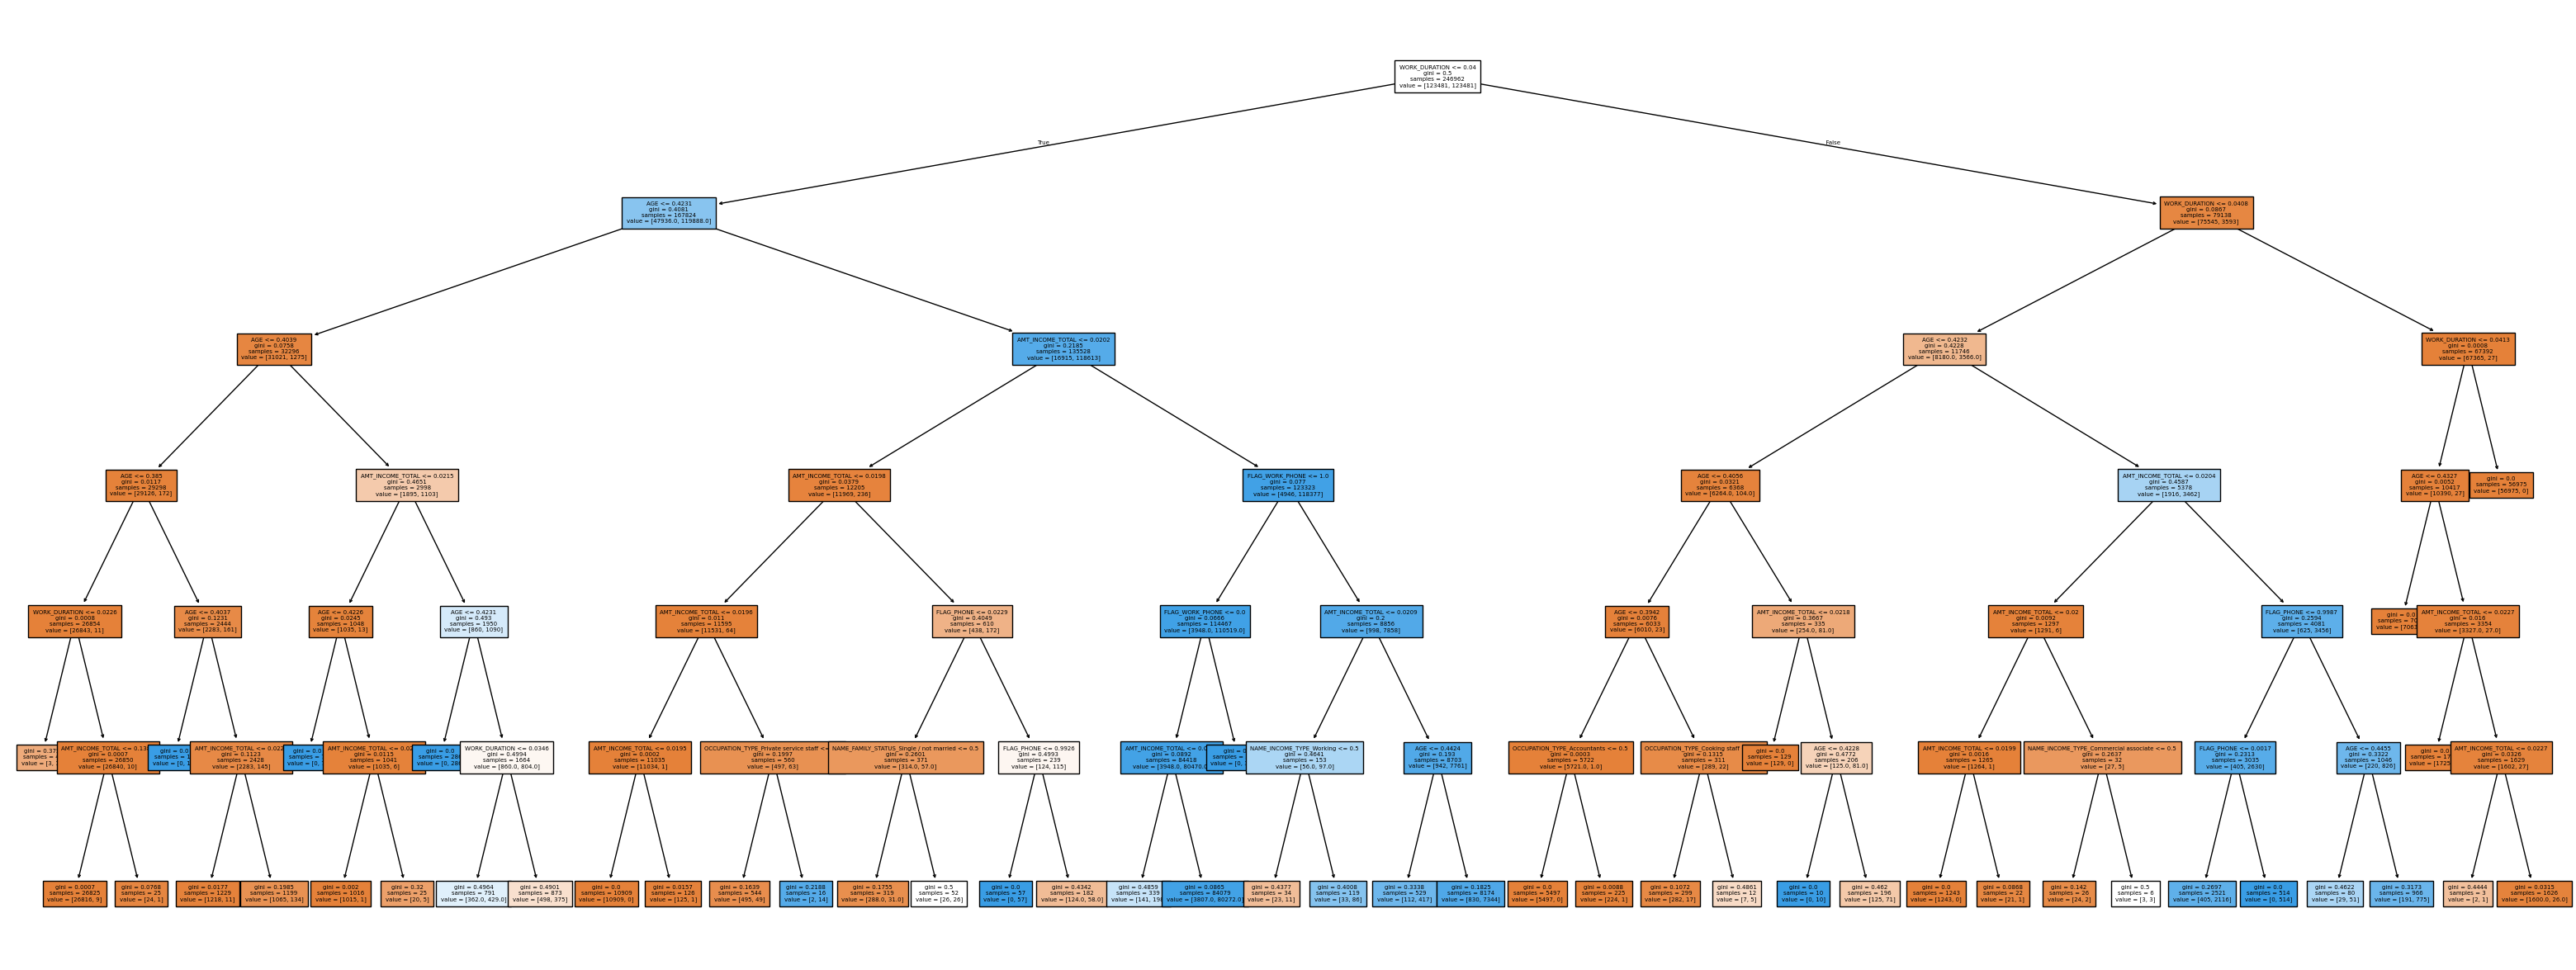

In [ ]:
plt.figure(figsize=(40, 15))
plot_tree(model4, feature_names=features_list, filled=True, max_depth=10, fontsize=5, precision = 4)
plt.show()

To better understand it, a random example with target = 0 is picked up and the negative creditworthiness is explained.

In [ ]:
df = pd.read_csv('https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv')
example_zero = df[df["TARGET"] == 0].sample(n=1, random_state=0)
print(example_zero)

             ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
290724  6832934           F            N               N             1   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
290724         111880.96  Commercial associate  Secondary / secondary special   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
290724            Married  House / apartment    -10486.0         -501.0   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
290724         1.0              0.0         0.0         0.0     Sales staff   

        CNT_FAM_MEMBERS  TARGET  
290724              3.0       0  


So, to explain why the random_selected example has a target value equal to 0, it is possible to follow the decision tree.
*  1st split: WORK_DURATION <= 0.0396. The value of example_zero of this feature is DAYS_EMPLOYED = -501. In order to compare these values, we must divide it by 365.25 and normalize it as normalization has been done for X_train.



In [ ]:
# From days to years
example_zero_work_duration = df.loc[290724, 'DAYS_EMPLOYED']//365.25
print(f"Work duration in year: {example_zero_work_duration:.2f}")

# Normalization:
example_zero_work_duration_norm = (example_zero_work_duration - min_work_epilogue)/(max_work_epilogue - min_work_epilogue)
print(f"Work duration normalized: {example_zero_work_duration_norm:.4f}")

Work duration in year: -2.00
Work duration normalized: 0.0426


WORK_DURATION for this example is equal to 0.0426, as a result form this split we go on the False side, on the right.
* 2nd split: WORK_DURATION <= 0.0408. We go on the False side, on the right.
* 3rd split: WORK_DURATION <= 0.0413. We go on the False side, on the right.
* Leaf node: contains 56 975 examples of Target = 0 and no example of Target = 1.

As a conclusion for this example_zero, we can say that it is due to her WORK_DURATION inferior to 2 years that she is labelled as not creditworthy.

As a conclusion, we created several models of Machine Learning, including class-weight argoment use for LogisticRegression, but also different kinds of Naive Bayes models, and finally the best one is a Decision Tree. </br>
Other models would probably have given much better metrics, but without possibility to interpretate and justify the target result.